## A Classifier for Aiding in Early Stage Diabetes Identification

This project uses [data](https://archive.ics.uci.edu/ml/datasets/Early+stage+diabetes+risk+prediction+dataset.#) provided by the [UCI ML Repository](https://archive.ics.uci.edu/ml/index.php). It should be noted that although the models appear to be quite effective at making an accurate diagnosis, we have very little information regarding the health background of those the data was collected from, and that many of these symptoms can be attributed to a rather large handful of different illnesses, health complications, etc. 

In [327]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
plt.rcParams['figure.dpi']= 100

import random
random.seed(5)

We will make a few different models: logistic regression, k-nearest neighbors, random forest, and support vector machines.

In [328]:
diabetes = pd.read_csv('diabetes_data_upload.csv')
diabetes.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


#### EDA

In [329]:
# Most interested in age range.
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 520 non-null    int64 
 1   Gender              520 non-null    object
 2   Polyuria            520 non-null    object
 3   Polydipsia          520 non-null    object
 4   sudden weight loss  520 non-null    object
 5   weakness            520 non-null    object
 6   Polyphagia          520 non-null    object
 7   Genital thrush      520 non-null    object
 8   visual blurring     520 non-null    object
 9   Itching             520 non-null    object
 10  Irritability        520 non-null    object
 11  delayed healing     520 non-null    object
 12  partial paresis     520 non-null    object
 13  muscle stiffness    520 non-null    object
 14  Alopecia            520 non-null    object
 15  Obesity             520 non-null    object
 16  class               520 no

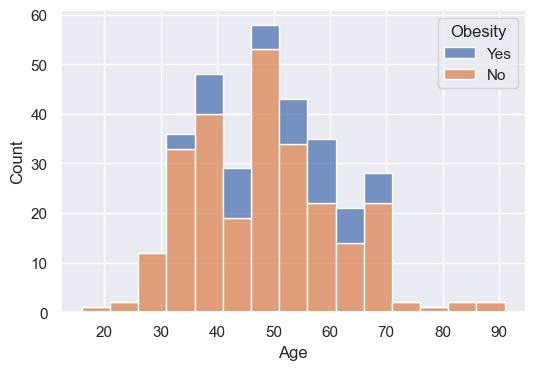

In [330]:
sns.histplot(data=diabetes[diabetes['class']=='Positive'], x='Age', hue='Obesity', binwidth=5,  multiple='stack');

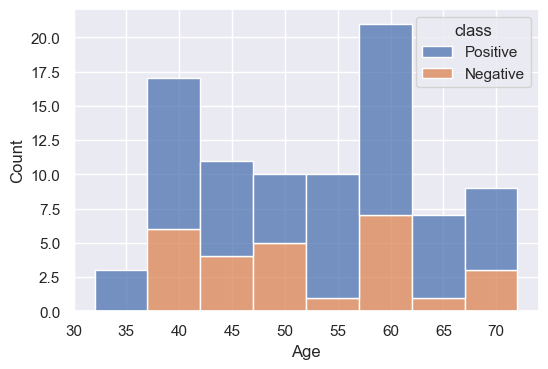

In [331]:
sns.histplot(data=diabetes[diabetes['Obesity']=='Yes'], x='Age', hue='class', binwidth=5,  multiple='stack');

Upon first seeing the data I was under the assumption that the reason for a lack of diagnoses among younger age groups was due to larger proportions of obesity among older groups. Evidently there are more obese cases amongst the older population, however not nearly enough to justify almost no diagnoses under the age of 25. 

We can also see that amongst the rather small obese group, there are far more positive diagnoses than negative.

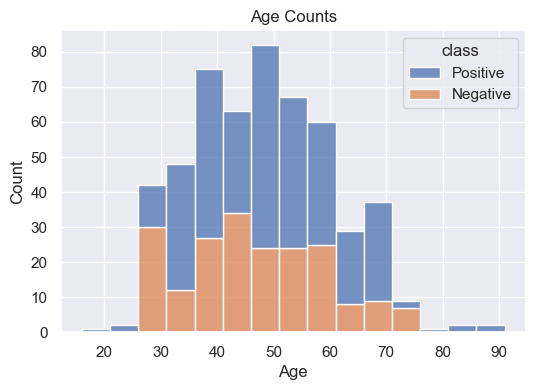

In [332]:
sns.histplot(data=diabetes, x='Age', hue='class', binwidth=5,  multiple='stack');
plt.title('Age Counts');

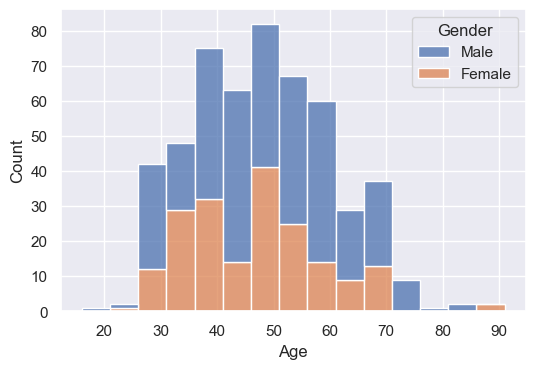

In [333]:
sns.histplot(data=diabetes, x='Age', hue='Gender', binwidth=5,  multiple='stack');


In [334]:
# Convert data to binary if appropriate
diabetes.Gender = diabetes.Gender.apply(lambda x: 1 if x =='Male' else 0)
diabetes['class'] = diabetes['class'].apply(lambda x: 1 if x=='Positive' else 0)
for feature in ['Polyuria', 'Polydipsia', 'sudden weight loss',
       'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring',
       'Itching', 'Irritability', 'delayed healing', 'partial paresis',
       'muscle stiffness', 'Alopecia', 'Obesity']:
       diabetes[feature] = diabetes[feature].apply(lambda x: 1 if x =='Yes' else 0)
diabetes.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,58,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,41,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,45,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,60,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1


Fortunately the data was prepared quite nicely so setting it up for modeling was very straightforward.

In [335]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Age                 520 non-null    int64
 1   Gender              520 non-null    int64
 2   Polyuria            520 non-null    int64
 3   Polydipsia          520 non-null    int64
 4   sudden weight loss  520 non-null    int64
 5   weakness            520 non-null    int64
 6   Polyphagia          520 non-null    int64
 7   Genital thrush      520 non-null    int64
 8   visual blurring     520 non-null    int64
 9   Itching             520 non-null    int64
 10  Irritability        520 non-null    int64
 11  delayed healing     520 non-null    int64
 12  partial paresis     520 non-null    int64
 13  muscle stiffness    520 non-null    int64
 14  Alopecia            520 non-null    int64
 15  Obesity             520 non-null    int64
 16  class               520 non-null    int64
dt

#### Model Selection

As mentioned earlier, will be fitting a few different models to compare classification accuracy. 

In [336]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [337]:
features = diabetes.loc[:, diabetes.columns != 'class']
labels = diabetes['class']
x_train, x_test, y_train, y_test = train_test_split(features, labels, train_size=0.75, random_state=5)
max_scores = {}

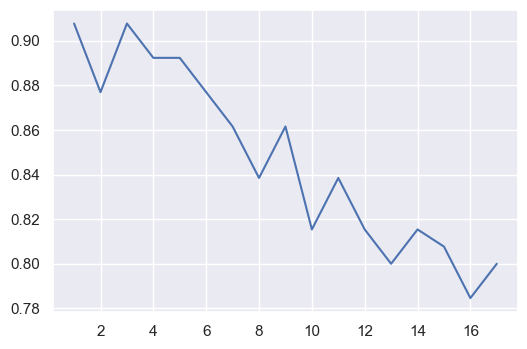

In [338]:
# KNeighbors
scores = []
max_score = 0
for k in range(1, 18):
    model = KNeighborsClassifier(n_neighbors=k) 
    model.fit(x_train, y_train)
    if model.score(x_test, y_test) > max_score: 
        max_score = model.score(x_test, y_test)
    scores.append(model.score(x_test, y_test))
max_scores['KNeighbors'] = max_score
plt.plot(range(1,18), scores);

In [339]:
# Logistic Regression
# Can look at feature selection select from model
# data = [x_train, y_train]
# scores = []
# for j in range(14):
#     model = LogisticRegression()
#     model.fit(x_train, y_train)
#     scores.append(model.score(x_test, y_test))
#     coefs = abs(model.coef_)
#     i = np.argmin(coefs)
#     for set in data:
#         set.drop(set.columns[i], axis=1, inplace=True)
#     j+=1

model_lr = LogisticRegression(max_iter=120)
model_lr.fit(x_train, y_train)
max_scores['Logistic Regression'] = model_lr.score(x_test, y_test)
max_scores

{'KNeighbors': 0.9076923076923077, 'Logistic Regression': 0.9307692307692308}

In [340]:
# SVM

model_svc = SVC(kernel='linear')
model_svc.fit(x_train, y_train)
max_scores['SVM'] = model_svc.score(x_test, y_test)

0.9846153846153847
0.9846153846153847
0.9846153846153847


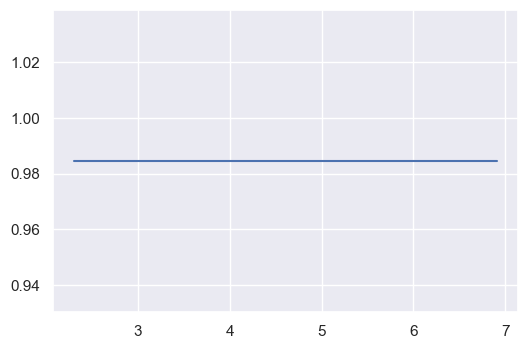

In [341]:
# Random forest
scores = []
max_score = 0
for i in [10, 100, 1000]:
    model_rf = RandomForestClassifier(n_estimators=i)
    model_rf.fit(x_train, y_train)
    print(model_rf.score(x_test, y_test))
    if model_rf.score(x_test, y_test) > max_score:
        max_score = model_rf.score(x_test, y_test)
    scores.append(model_rf.score(x_test, y_test))

max_scores['RandomForestClassifier'] = max_score
estimators = [np.log(i) for i in [10, 100, 1000]]
plt.plot(estimators, scores );



In [342]:
max_scores

{'KNeighbors': 0.9076923076923077,
 'Logistic Regression': 0.9307692307692308,
 'SVM': 0.9307692307692308,
 'RandomForestClassifier': 0.9846153846153847}

Evidently the Random Forest Classifier with n_estimators=100 is the best model so far.

Now that we have assessed model performace, we can train the model on the full dataset and use it to predict more specific results. 

In [343]:
features = diabetes.loc[:, diabetes.columns!='class']
labels = diabetes['class']
rfc_model = RandomForestClassifier(n_estimators=100)
rfc_model.fit(features, labels)

RandomForestClassifier()

In [344]:
diabetes.columns

Index(['Age', 'Gender', 'Polyuria', 'Polydipsia', 'sudden weight loss',
       'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring',
       'Itching', 'Irritability', 'delayed healing', 'partial paresis',
       'muscle stiffness', 'Alopecia', 'Obesity', 'class'],
      dtype='object')

In [345]:
def predict_individual(person):
    likelihood = rfc_model.predict_proba(person)[0][1]
    return 'Likelihood prediction of diabetes: ' + str(likelihood)

In [346]:
individual_1 = [[22, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0]]
individual_2 = [[20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]]
individual_3 = [[24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
print(predict_individual(individual_1))
print(predict_individual(individual_2))
print(predict_individual(individual_3))

Likelihood prediction of diabetes: 0.84
Likelihood prediction of diabetes: 0.28
Likelihood prediction of diabetes: 0.12
